In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from helpers import *
import tensorflow as tf
from tensorflow.keras import layers, Model

from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers.experimental import preprocessing
import pprint
import numpy as np
import matplotlib.pyplot as plt
import os
import rasterio.io
import statistics
import rasterio.features
import rasterio.warp
from rasterio.plot import show
import warnings

total products = 7069
total products after filtering cloudy images = 1056
reviewing values before scaling
b'../../data/HiltonOfFern_crop_field_training_cloud_free_available_area/20180827/ROI1/S2/Patches/S1_f78df197-5814-44ea-bfff-351e5e1ddb50_S2_722cd3b3-d490-4d4d-8de5-891e19d25d95_0_1792_256x256.tif' has the highest value we've seen 1932.0
avg value for b'../../data/HiltonOfFern_crop_field_training_cloud_free_available_area/20180827/ROI1/S2/Patches/S1_f78df197-5814-44ea-bfff-351e5e1ddb50_S2_722cd3b3-d490-4d4d-8de5-891e19d25d95_0_1792_256x256.tif' before rescaling is 188.54521


b'../../data/HiltonOfFern_crop_field_training_cloud_free_available_area/20180827/ROI1/S2/Patches/S1_f78df197-5814-44ea-bfff-351e5e1ddb50_S2_722cd3b3-d490-4d4d-8de5-891e19d25d95_0_4096_256x256.tif' has the highest value we've seen 2548.0
avg value for b'../../data/HiltonOfFern_crop_field_training_cloud_free_available_area/20180827/ROI1/S2/Patches/S1_f78df197-5814-44ea-bfff-351e5e1ddb50_S2_722cd3b3-d490-4d4d-8de5

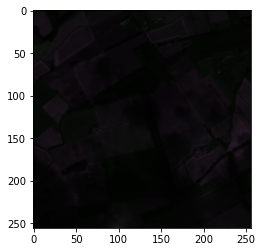

In [10]:
DATASET_ROOT_PATH = '../../data/HiltonOfFern_crop_field_training_cloud_free_available_area'
HALF_MAX_RGB_INTENSITY = 9144.0
BATCH_SIZE = 1

list_ds = tf.data.Dataset.list_files(DATASET_ROOT_PATH + '/*/*/S2/Patches/*.tif', shuffle=False)
filenames = []
max_values_before_scaling = []
max_values_after_scaling = []


before_rescale_ds_avg = 0
after_rescale_ds_avg = 0
max_so_far = 0
scaled_max_so_far = 0

total_products = tf.data.experimental.cardinality(list_ds).numpy()
print("total products = " + str(total_products))
list_ds = list_ds.filter(cloudy_or_black_images_filter)
# unfortunately filtering sets the cardinality for the dataset to -2 (unkown) so have to manually set it or will cause an error
# when try to iterate through dataset during training
list_ds = list_ds.apply(tf.data.experimental.assert_cardinality(len(list(list_ds))))
total_products = tf.data.experimental.cardinality(list_ds).numpy()
print("total products after filtering cloudy images = " + str(total_products))

# map filenames for debugging
for cur_element in list_ds:
    filenames.append(cur_element.numpy())


list_ds = list_ds.map(process_path)
list_ds.apply(tf.data.experimental.ignore_errors())
counter = 0
print("reviewing values before scaling")
# rescale sentinel 2 rgb values to between -1 and 1 (as we use tan for generator output)
for cur_element in list_ds:
    cur_filename = filenames[counter]
    counter = counter + 1
    max_value = tf.experimental.numpy.amax(cur_element[1])
    max_values_before_scaling.append(max_value.numpy())
    avg_value = tf.math.reduce_mean(cur_element[1])
    before_rescale_ds_avg = before_rescale_ds_avg + avg_value
    if max_value > max_so_far:
        print(str(cur_filename) + " has the highest value we've seen " + str(max_value.numpy()))
        print("avg value for " + str(cur_filename) + " before rescaling is " + str(avg_value.numpy()) + "\n\n")
        max_so_far = max_value
    
before_rescale_ds_avg = before_rescale_ds_avg / total_products
print("average value in dataset before rescaling = " + str(before_rescale_ds_avg.numpy()) + "\n\n")
print("have " + str(len(max_values_before_scaling)) + " values in max_values_before_scaling list")
rescaling_layer = Rescaling(scale = 1./HALF_MAX_RGB_INTENSITY, offset=-1.)
list_ds = list_ds.map(lambda x, y: (x, rescaling_layer(y)))

#list_ds = train_ds.batch(BATCH_SIZE).repeat()

counter = 0
for cur_element in list_ds:
    cur_filename = filenames[counter]
    counter = counter + 1
    
    max_value = tf.experimental.numpy.amax(cur_element[1])
    max_values_after_scaling.append(max_value.numpy())
    min_value = tf.experimental.numpy.amin(cur_element[1])
    avg_value = tf.math.reduce_mean(cur_element[1])
    after_rescale_ds_avg = after_rescale_ds_avg + avg_value
    if max_value > scaled_max_so_far:
        print(str(cur_filename) + "has the highest value we've seen so far after rescaling: " + str(max_value.numpy()))
        print("min value for " + str(cur_filename) + " after rescaling is " + str(min_value.numpy()))
        print("avg value for " + str(cur_filename) + " after rescaling is " + str(avg_value.numpy())  + "\n\n")
        scaled_max_so_far = max_value
    plt.imshow((cur_element[1]+1)/2)

after_rescale_ds_avg = after_rescale_ds_avg / total_products
print("average value in dataset after rescaling = " + str(after_rescale_ds_avg.numpy()))
print("have " + str(len(max_values_after_scaling)) + " values in max_values_after_scaling list")
max_values_before_scaling =np.asarray(max_values_before_scaling)
print("standard deviation of max values before scaling = " + str(np.std(max_values_before_scaling)))
print("max value before scaling = " + str(max(max_values_before_scaling)))
print("average image max value before scaling = " + str(np.average(max_values_before_scaling)))
max_values_after_scaling =np.asarray(max_values_after_scaling)
print("standard deviation of max values after scaling = " + str(np.std(max_values_after_scaling)))
print("max value after scaling = " + str(max(max_values_after_scaling)))